## This notebook contains exploratory data analysis of data used for training.  

In [1]:
import os
import random
import zipfile

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.transforms import Resize, Compose
from PIL import Image

from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Computer Vision Animals-10 dataset

##### For the Computer Vision part of the task I have chosen the Animals-10 dataset by `alessiocorrado99` from Kaggle. 
 
One can download it from `Kaggle` or use a local version.

In [6]:
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

In [2]:
root = os.path.join(path, 'raw-img') # kaggle
# root = '../task2/data/animals10/raw-img' # locally

##### Load animal images into a dataframe.
For simplicity I am only using first 100 images for each class, as it is enough fro exploratory analysis. 
The full dataset is imbalanced, I used first 1446 images when training. Another approach would be to load everything and use an Under Sampler. I would not use an Over Sampler here. 

In [25]:
image_paths = []
labels = []

# for each animal (separate folder for each)
for animal in os.listdir(root):
    # join the animal folder to path
    path = os.path.join(root, animal)
    # use first 100 images to make sure the dataset is balanced
    for img in os.listdir(path)[:100]:
        # add image path
        image_paths.append(os.path.join(path, img))
        # add label (animal name)
        labels.append(animal)

In [26]:
df = pd.DataFrame({
    'image_paths' : image_paths,
    'labels' : labels
})
df.head(10)

,image_paths,labels
0,../task2/data/animals10/raw-img\cane\OIF-e2bex...,cane
1,../task2/data/animals10/raw-img\cane\OIP---A27...,cane
2,../task2/data/animals10/raw-img\cane\OIP---cBy...,cane
3,../task2/data/animals10/raw-img\cane\OIP---ZId...,cane
4,../task2/data/animals10/raw-img\cane\OIP---ZRs...,cane
5,../task2/data/animals10/raw-img\cane\OIP---_cJ...,cane
6,../task2/data/animals10/raw-img\cane\OIP--0C2k...,cane
7,../task2/data/animals10/raw-img\cane\OIP--0CZn...,cane
8,../task2/data/animals10/raw-img\cane\OIP--1QXr...,cane
9,../task2/data/animals10/raw-img\cane\OIP--2uTt...,cane


##### Translate the labels
Since the original dataset is in Italian, here is a way to translate the labels to English, as well as convert index to label and back.

In [27]:
label = {"cane": "dog",
         "cavallo": "horse",
         "elefante": "elephant",
         "farfalla": "butterfly",
         "gallina": "chicken",
         "gatto": "cat",
         "mucca": "cow",
         "pecora": "sheep",
         "ragno" : "spider",
         "scoiattolo": "squirrel"}

label_to_index = {key: idx for idx, key in enumerate(label.keys())}
index_to_label = {idx: value for key, value in label.items() for idx, k in enumerate(label.keys()) if k == key}

In [28]:
df['labels_num'] = df['labels'].map(label_to_index)
df['labels'] = df['labels'].map(label)
df.head(10)

,image_paths,labels,labels_num
0,../task2/data/animals10/raw-img\cane\OIF-e2bex...,dog,0
1,../task2/data/animals10/raw-img\cane\OIP---A27...,dog,0
2,../task2/data/animals10/raw-img\cane\OIP---cBy...,dog,0
3,../task2/data/animals10/raw-img\cane\OIP---ZId...,dog,0
4,../task2/data/animals10/raw-img\cane\OIP---ZRs...,dog,0
5,../task2/data/animals10/raw-img\cane\OIP---_cJ...,dog,0
6,../task2/data/animals10/raw-img\cane\OIP--0C2k...,dog,0
7,../task2/data/animals10/raw-img\cane\OIP--0CZn...,dog,0
8,../task2/data/animals10/raw-img\cane\OIP--1QXr...,dog,0
9,../task2/data/animals10/raw-img\cane\OIP--2uTt...,dog,0


##### The data is balanced

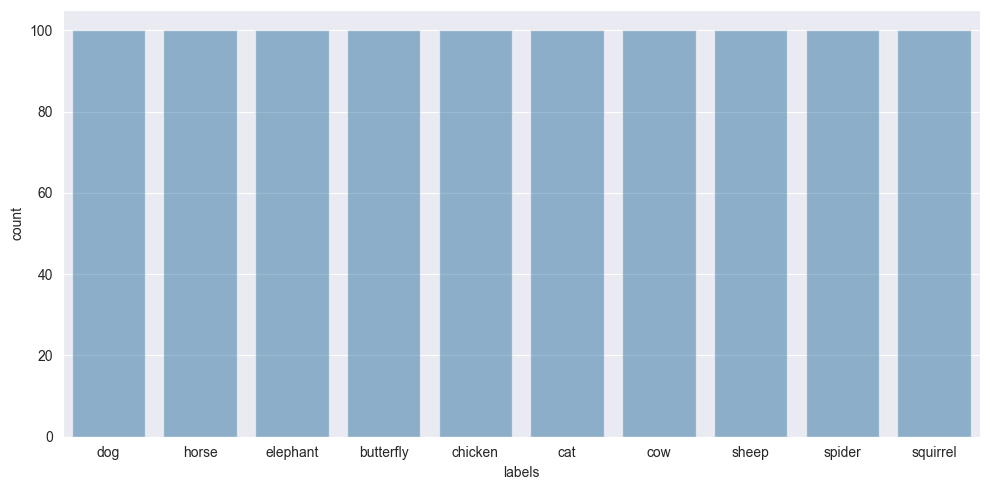

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(df, x='labels', alpha = 0.5)
plt.tight_layout()

In [30]:
df.value_counts('labels')

labels
butterfly    100
cat          100
chicken      100
cow          100
dog          100
elephant     100
horse        100
sheep        100
spider       100
squirrel     100
Name: count, dtype: int64

##### Lets take a look at a few dataset pictures

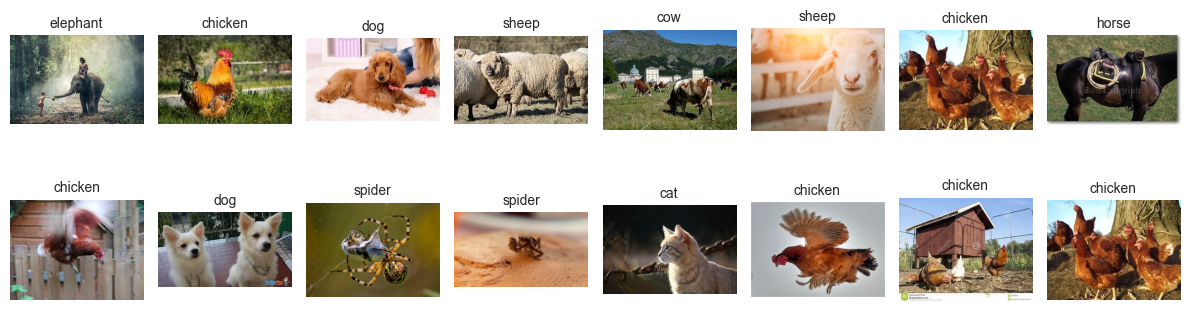

In [31]:
fig,ax = plt.subplots(2, 8, figsize=(12, 4))
ax = ax.flatten()

for idx in range(len(ax)):
    rd_id = np.random.randint(0, df.shape[0])
    image = plt.imread(df['image_paths'].iloc[rd_id])
    ax[idx].imshow(image)
    ax[idx].set_title(df['labels'].iloc[rd_id], fontsize = 10)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

##### As we may see, there are many different pictures all in different sizes. Let's preprocess them

In [38]:
all_images = []

def processing_image(image_path, size=(224,224)):
    # read an image
    image = cv2.imread(image_path)
    # cv2 reads image in BGR so convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize to make sure dimensions are the same for all the pictures
    image = cv2.resize(image, size)
    return image

for i in df['image_paths'].values:
    image = processing_image(i)
    all_images.append(image)

##### All images are square now

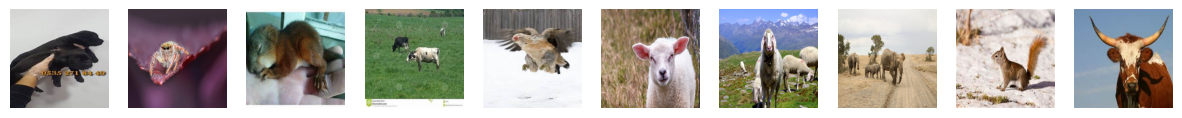

In [39]:
def show_random_images(images, n=5):
    random_images = random.sample(images, n)
    plt.figure(figsize=(15, 5))

    for i, img in enumerate(random_images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Show 5 random images (change n to any number)
show_random_images(all_images, n=10)

In [40]:
all_images = np.array(all_images)

##### Split the data 80 / 10 / 10

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, df['labels_num'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels_num']
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)


print(X_train.shape,y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(800, 224, 224, 3) (800,)
(100, 224, 224, 3) (100,)
(100, 224, 224, 3) (100,)


In [20]:
aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 0.18,
    zoom_range = 0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [21]:
vgg16 = VGG16(
    input_shape = (224,224,3),
    include_top = False,
)

In [22]:
for layer in vgg16.layers:
    layer.trainable = False

In [23]:
x = vgg16.layers[-1].output
x = Flatten()(x)
x = Dense(512)(x)
x = Activation('relu')(x)
output = Dense(10, activation='softmax')(x)
vgg16_1 = Model(vgg16.input,output)
vgg16_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 12,850,698 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
learning_rate = 0.001
epochs = 50
batch_size = 32
factor = 0.2

vgg16_1.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
)

In [25]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= factor, patience=3, min_lr=1e-7)
checkpoint_cb = ModelCheckpoint('../task2/vgg16/model_epoch_{epoch:02d}.keras', save_freq='epoch')

In [26]:
history = vgg16_1.fit(
    aug.flow(x_train, y_train, batch_size=batch_size),
    validation_data = (x_valid,y_valid),
    epochs = epochs,
    callbacks = [early_stopping , reduce_lr, checkpoint_cb]
)

C:\IT\WinstarsAI\WinstarsAI_InternshipTest_SofiiaHrychukh\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1183s 5s/step - accuracy: 0.4880 - loss: 2.5481 - val_accuracy: 0.6844 - val_loss: 23.7200 - learning_rate: 0.0010
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1181s 5s/step - accuracy: 0.7439 - loss: 0.7589 - val_accuracy: 0.7233 - val_loss: 22.1338 - learning_rate: 0.0010
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1145s 5s/step - accuracy: 0.7682 - loss: 0.6633 - val_accuracy: 0.7544 - val_loss: 22.5657 - learning_rate: 0.0010
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1141s 4s/step - accuracy: 0.7971 - loss: 0.5991 - val_accuracy: 0.7544 - val_loss: 26.3127 - learning_rate: 0.0010
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1131s 4s/step - accuracy: 0.7895 - loss: 0.6223 - val_accuracy: 0.7744 - val_loss: 23.9028 - learning_rate: 0.0010
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1136s 4s/step - accuracy: 0.8476 - loss: 0.4587 - val_accuracy: 0.7533 - val_loss: 26.8616 - learning_rate: 2.0000e-04
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1118s 4s/step - accuracy: 

In [27]:
vgg16_1.save('../task2/vgg16/vgg16_model.keras')

In [28]:
vgg16_load = keras.models.load_model('../task2/vgg16/vgg16_model.keras')

In [29]:
loss, accuracy = vgg16_load.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.7411 - loss: 16.2985
